# **Advances in Modeling High-Energy Astrophysical Sources:** 
## Insights from recent multimessenger discoveries 

### *Gammapy Hands-on: 2nd session*

#### **Installation reminder**

Brief suggestion of installation, check [here](https://docs.gammapy.org/dev/getting-started/index.html#getting-started) for more

In [ ]:
# Conda installation, recommended to create an environment

$ conda create --name gammapy-sexten
$ conda activate gammapy-sexten # stop with '$ conda deactivate'
$ conda install -c conda-forge gammapy
$ conda install notebook

## Alternatively, you could install it via pip
$ pip install gammapy


In [1]:
# Today you might also need...
! conda install -y ipywidgets

done
^Clving environment: \ 
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



*Disclaimer*:
The following tutorials are based almost completely on the those available at the [gammapy docs](https://docs.gammapy.org/dev/index.html). All credit of images, data, and other materials should go to the original authors. You will also find more information there that the one we can cover here. You might also want to have a look at this review on Gamma-Ray Data Analysis by [Denys Malyshev and Lars Mohrmann (2023)](https://arxiv.org/pdf/2309.02966).

#### **Survey**

Many thanks to those who filled it!

#### **Introduction to detection significance**

On Tuesday we saw how in the crab there was a clear excess of counts and how this translated to a significance

![workflow](Crab_significances.png)

... but what does this significance mean?

In gamma-ray astronomy, we tipically have (there are many ways!):

- On/Off method + [Li & Ma 1983](https://articles.adsabs.harvard.edu/pdf/1983ApJ...272..317L):

![workflow](On-OFF.png) (Image credit to Berge, Funk, and Hinton 2007) 

![workflow](Excess.png)
![workflow](Significance.png)

- Likleihood approach (Test Statistic, TS):

![workflow](Likelihood.png)

![workflow](TS.png)

Since we will do quite some likelihood fits today, let's see two common misconceptions:
1) The square root of TS **is not** the number of sigmas. It is approximately the number of sigmas for 1 d.o.f. only
2) An upper limit **is not** 2x the error of a non detection.


#### **2D analysis - Ring background**

In this tutorial we will analyse H.E.S.S. data again, now of the pulsar wind nebula MSH 15-52. In the process we will attempt to learn 3 new things:

- Do an analysis with a configuration file
- Take background using the ring method instead of reflected regions
- Have a look at residual maps

In [1]:
### Setup 
import logging

# %matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import RingBackgroundMaker
from gammapy.visualization import plot_distribution
from gammapy.utils.check import check_tutorials_setup
from gammapy.data import DataStore, EventList

log = logging.getLogger(__name__)


In [2]:
### Check setup
check_tutorials_setup()


System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

Now, we create a config file for our analysis.
Why creating a YAML config file? 

-> Simple: it may be easier to handle and keep things under control (in gammapy frequently mentioned as "high level interface"). What we did on Tuesday was using the "low level interface".

Basically what we will do is:

Create an AnalysisConfig object and edit it to define the analysis configuration:

    - Define what observations to use

    - Define the geometry of the dataset (data and IRFs)

    - Define the model we want to fit on the dataset.

Instantiate a Analysis from this configuration and run the different analysis steps

    - Observation selection

    - Data reduction
    

In [3]:

# source_pos = SkyCoord.from_name("MSH 15-52") # -> You could call it by name
source_pos = SkyCoord(228.32, -59.08, unit="deg")

config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = "$GAMMAPY_DATA/hess-dl3-dr1/"
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 2.5 * u.deg,
}

config.datasets.type = "3d" # It is good practice to always have the chance to do 3D, but you will see that we won't use that
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  # The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.width = {"width": "3 deg", "height": "3 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 2.5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.5 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

print(config)

AnalysisConfig

    general:
        log:
            level: info
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /home/willde/Programes/gammapy-datasets/1.0.1/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: icrs
            lon: 228.32 deg
            lat: -59.08 deg
            radius: 2.5 deg
        obs_time:
            start: null
            stop: null
        required_irf:
        - aeff
        - edisp
        - psf
        - bkg
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir:
                    frame: icrs
                    lon: 228.32 deg
                    lat: -59.08 deg
                binsize: 0.02 deg
                width:
                    width: 3.0 deg
                    heigh

In [4]:
# You can write it into a YAML file or load it

# Save
#config.write("config.yaml", overwrite=True)

# Load
#config = AnalysisConfig.read("config.yaml")

In [5]:
# We now use the config file to do the initial data reduction
# which will then be used for a ring extraction

analysis = Analysis(config)

# for this specific case,w e do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# First get the required observations
analysis.get_observations()

print(analysis.config)


Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 20 out of 20.
Number of selected observations: 20


AnalysisConfig

    general:
        log:
            level: INFO
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /home/willde/Programes/gammapy-datasets/1.0.1/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: icrs
            lon: 228.32 deg
            lat: -59.08 deg
            radius: 2.5 deg
        obs_time:
            start: null
            stop: null
        required_irf:
        - aeff
        - edisp
        - psf
        - bkg
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir:
                    frame: icrs
                    lon: 228.32 deg
                    lat: -59.08 deg
                binsize: 0.02 deg
                width:
                    width: 3.0 deg
                    heigh

In [6]:
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 20136
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20137
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20151
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20282
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20283
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20301
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20302
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20303
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20322
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 20323
Running MapDatasetMaker
Running SafeMas

In [7]:
## We can check the observations
print(analysis.observations.ids)


['20136', '20137', '20151', '20282', '20283', '20301', '20302', '20303', '20322', '20323', '20324', '20325', '20343', '20344', '20345', '20346', '20365', '20366', '20367', '20368']


In [8]:
## Remember, if we want to use the low level interface we could! and we see that we would be doing the same
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="228.32 deg",
    lat="-59.08 deg",
    radius="2.5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations.ids)

Observations selected: 20 out of 20.


['20136', '20137', '20151', '20282', '20283', '20301', '20302', '20303', '20322', '20323', '20324', '20325', '20343', '20344', '20345', '20346', '20365', '20366', '20367', '20368']


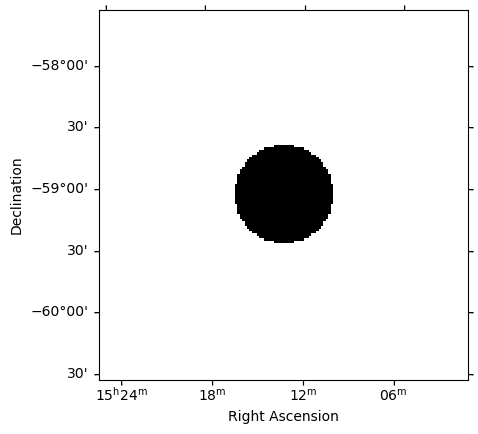

In [9]:
# Remember the exclusion region from the last time?
# For extended sources in particular, would be good to exclude the source itself, just in case

# get the geom that we use
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.4 * u.deg)
exclusion_mask = ~geom_image.region_mask([regions])
exclusion_mask.sum_over_axes().plot()
plt.show()


In [10]:
# And we create the Ring Maker
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

# NOTE: Ring background is particularly useful (and almost exclusive) for 2D analyses


We extract the background for each dataset and then stack the maps together to create a single stacked map for further analysis

In [11]:
energy_axis_true = analysis.datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

for dataset in analysis.datasets:
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

# So stacked_on_off has on and off counts and acceptance maps
print(stacked_on_off)


MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 41803 
  Total background counts         : 40671.90
  Total excess counts             : 1131.10

  Predicted counts                : 40672.37
  Predicted background counts     : 40672.37
  Predicted excess counts         : nan

  Exposure min                    : 1.15e+09 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26475.50

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 87621192 
  Acceptance                      : 44755 
  Acceptance off                  : 96374320 



And it is finally time to create the maps!

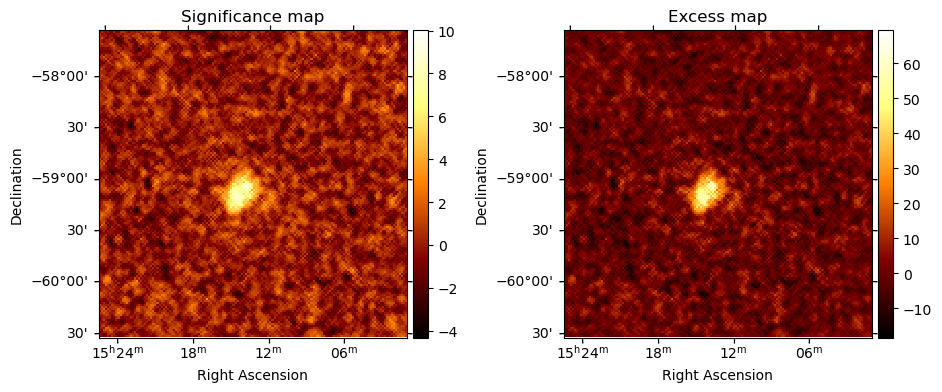

In [12]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[], correlate_off=False)
# Note:correlate_off=False is necessary for Ring background!

lima_maps = estimator.run(stacked_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 4), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)
ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)
plt.show()


Specially for maps, we need to evaluate that everything went well, that is, background regions should follow a Gaussian distribution!

/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/stats/counts_statistic.py:398: RuntimeWarning: invalid value encountered in multiply
  return self.alpha * self.n_off
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/stats/fit_statistics.py:207: RuntimeWarning: invalid value encountered in multiply
  C = alpha * (n_on + n_off) - (1 + alpha) * mu_sig
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/stats/fit_statistics.py:208: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


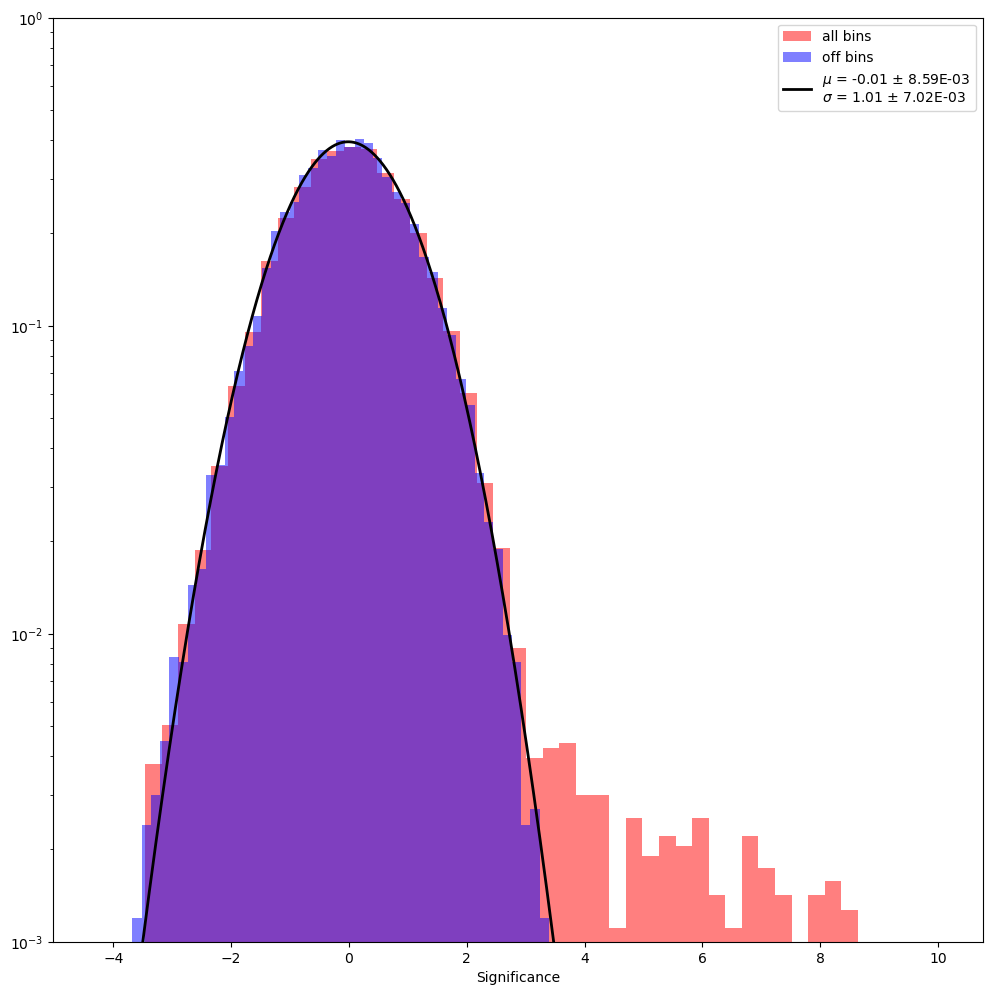

In [13]:
# We do the same but now excluding the source with the mask we created earlier
stacked_on_off.mask_fit = exclusion_mask 
lima_maps2 = estimator.run(stacked_on_off)
significance_map_off = lima_maps2["sqrt_ts"]

kwargs_axes = {"xlabel": "Significance", "yscale": "log", "ylim": (1e-3, 1)}
ax, _ = plot_distribution(
    significance_map,
    kwargs_hist={
        "density": True,
        "alpha": 0.5,
        "color": "red",
        "label": "all bins",
        "bins": 51,
    },
    kwargs_axes=kwargs_axes,
)

ax, res = plot_distribution(
    significance_map_off,
    ax=ax,
    func="norm",
    kwargs_hist={
        "density": True,
        "alpha": 0.5,
        "color": "blue",
        "label": "off bins",
        "bins": 51,
    },
    kwargs_axes=kwargs_axes,
)

plt.show()


#### **Towards 3D: 2D Maximum Likelihood and Search for new sources**

In this tutorial we will have a peek at Fermi data. In the process we will attempt to learn 3 new things:

- Check how a likelihood analysis works
- Find excesses...
- And derive their general properties

In [14]:
# Let's do the usual setup
import numpy as np
import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.datasets import MapDataset
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks, find_peaks_in_flux_map
from gammapy.irf import EDispKernelMap, PSFMap
from gammapy.maps import Map
from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel, SkyModel

In [15]:
# and check it 
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()



System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

In [16]:
### Reading Fermi data (based on 3FHL), more on Fermi later in the third session

counts = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts-cube.fits.gz")
background = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-background-cube.fits.gz"
)

exposure = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-exposure-cube.fits.gz")

psfmap = PSFMap.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-psf-cube.fits.gz",
    format="gtpsf",
)

edisp = EDispKernelMap.from_diagonal_response(
    energy_axis=counts.geom.axes["energy"],
    energy_axis_true=exposure.geom.axes["energy_true"],
)

dataset = MapDataset(
    counts=counts,
    background=background,
    exposure=exposure,
    psf=psfmap,
    name="fermi-3fhl-gc",
    edisp=edisp,
)

Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'.


So now we have our dataset. And we want, first of all to construct a TS map. In gammapy, this is done by fitting by a single amplitude parameter on each pixel. For this, we will assume that the photon index is 2, and thus we will only use 2D, just summing up over energies.

In [17]:
# Remember the spectral model from yesterday? Now we can add a spatial model
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-22 cm-2 s-1 keV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)


In [18]:
# And we run a estimator, now for a map
estimator = TSMapEstimator(
    model=model,
    kernel_width="1 deg",
    energy_edges=[10, 500] * u.GeV,
    n_sigma=1,
    n_sigma_ul=2,
    selection_optional=None,
    n_jobs=1,
    sum_over_energy_groups=True,
)

# Definitions

#    model: a SkyModel which is converted to a source model kernel
#    kernel_width: the width for the above kernel
#    n_sigma: number of sigma for the flux error
#    n_sigma_ul: the number of sigma for the flux upper limits
#    selection_optional: what optional maps to compute
#    n_jobs: for running in parallel, the number of processes used for the computation
#    sum_over_energy_groups: to sum over the energy groups or fit the norm on the full energy cube


maps = estimator.run(dataset)

Text(0.5, 1.0, 'Flux map')

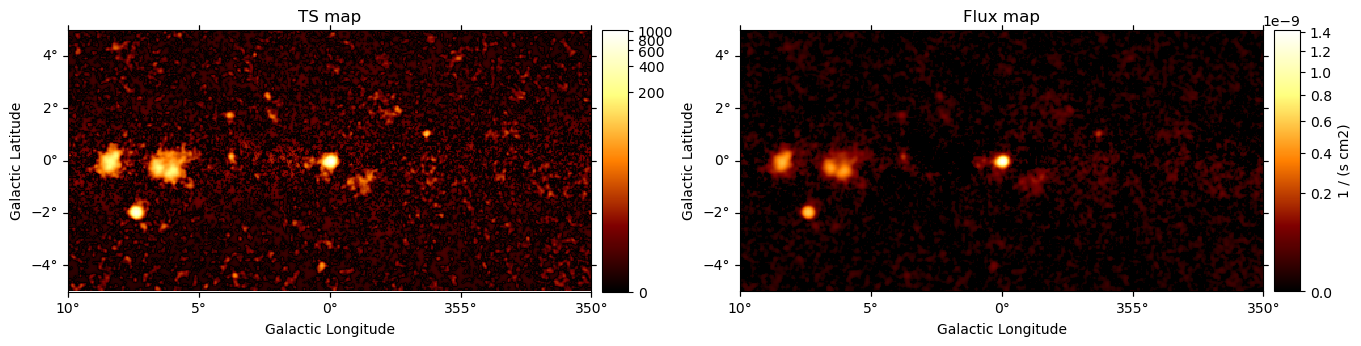

In [19]:
# And let's see what we generated!
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(14, 5),
    subplot_kw={"projection": counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["ts"].plot(ax=ax1, add_cbar=True, stretch='log', vmin=0)
ax1.set_title("TS map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")


# Note on gammapy TS derivation: TS is by definition only positive,
# but gammapy assigns a negative value if the count excess is negative

And now we are ready to look for new sources. This is done by using the find_peaks function, which performs a local maximum search in a sliding window. Note that this method is only looking for point-like sources.

In [20]:
# Search
sources = find_peaks(maps["ts"], threshold=25, min_distance="0.25 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()


<Table length=18>
 value    x     y       ra       dec   
                       deg       deg   
float64 int64 int64  float64   float64 
------- ----- ----- --------- ---------
 1036.5   200    99 266.41449 -28.97054
 774.67    52    60 272.43197 -23.54282
 229.82    32    98 271.16056 -21.74479
 199.76    69    93 270.40919 -23.47797
 192.42    80    92 270.15899 -23.98049
 95.331   273   119 263.18257 -31.52587
 77.317   124   102 268.46711 -25.63326
  54.01   123   134 266.97596 -24.77174
 46.336   193    19 270.59696 -30.69138
 38.977   152   148 265.48068 -25.64323
 34.462   230    86 266.15140 -30.58926
 32.124   127    12 272.77351 -27.97934
 31.987   251   139 262.90685 -30.05853
 29.934   181    95 267.17020 -28.26173
 29.387   214    83 266.78188 -29.98429
 26.766    57    49 272.82739 -24.02653
 25.674   156   132 266.12148 -26.23306
 25.416    93    80 270.37773 -24.84233

In [21]:
# Alternatively, you can look for the peaks on the flux map and get all information from the flux as well

sources_flux_map = find_peaks_in_flux_map(maps, threshold=5, min_distance="0.25 deg") # Caution! The threshold is defined for 1 d.o.f.
display(sources_flux_map)

<Table length=18>
  x     y       ra       dec    ... stat_null  success     flux      flux_err 
               deg       deg    ...                    1 / (s cm2) 1 / (s cm2)
int64 int64  float64   float64  ...  float64     bool    float64     float64  
----- ----- --------- --------- ... ---------- ------- ----------- -----------
   93    80 270.37773 -24.84233 ...  840.62111    True   8.105e-11   2.332e-11
  156   132 266.12148 -26.23306 ...  692.59451    True   5.880e-11   1.859e-11
   57    49 272.82739 -24.02653 ...  723.70546    True   5.572e-11   1.729e-11
  214    83 266.78188 -29.98429 ...  838.88781    True   9.695e-11   2.583e-11
  181    95 267.17020 -28.26173 ...  659.39224    True   1.286e-10   3.165e-11
  251   139 262.90685 -30.05853 ...  766.22149    True   6.664e-11   1.913e-11
  127    12 272.77351 -27.97934 ...  433.37517    True   4.107e-11   1.349e-11
  230    86 266.15140 -30.58926 ...  865.54892    True   1.278e-10   3.040e-11
  152   148 265.48068 -25.64323 ...  611.76473    True   7.080e-11   1.876e-11
  193    19 270.59696 -30.69138 ...  445.28958    True   6.612e-11   1.711e-11
  123   134 266.97596 -24.77174 ...  655.77218    True   9.207e-11   2.123e-11
  124   102 268.46711 -25.63326 ...  881.98258    True   1.702e-10   3.050e-11
  273   119 263.18257 -31.52587 ...  846.92490    True   1.763e-10   2.947e-11
   80    92 270.15899 -23.98049 ... 1093.46225    True   4.576e-10   5.278e-11
   69    93 270.40919 -23.47797 ... 1044.25763    True   4.553e-10   5.259e-11
   32    98 271.16056 -21.74479 ... 1036.42361    True   5.401e-10   5.794e-11
   52    60 272.43197 -23.54282 ... 1092.41995    True   5.984e-10   4.669e-11
  200    99 266.41449 -28.97054 ...  137.30287    True   1.414e-09   7.898e-11

#### **3D analysis: The Galactic Center**

We 3D map based analysis on the galactic center, using simulated observations from the CTA Data Challenge. We will use the high level interface for the data reduction, and then do a detailed modelling. Again, this can be done with a joint fit or detailed modelling.


In [22]:
# As always, load necessary packages
from pathlib import Path
import astropy.units as u
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.visualization import plot_distribution
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.selection import select_nested_models
from gammapy.modeling import Fit
from gammapy.stats.utils import ts_to_sigma
from gammapy.maps import Map
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    PowerLawNormSpectralModel,
    FoVBackgroundModel,
    TemplateSpatialModel,
    Models,
    PointSpatialModel,
    SkyModel,
)


In [23]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

In this section we select observations and define the analysis geometries, irrespective of joint/stacked analysis. For configuration of the analysis, we will programmatically build a config file from scratch.

In [24]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Now we will definitively use it

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

print(config)

AnalysisConfig

    general:
        log:
            level: info
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /home/willde/Programes/gammapy-datasets/1.0.1/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: null
            lon: null
            lat: null
            radius: null
        obs_time:
            start: null
            stop: null
        required_irf:
        - aeff
        - edisp
        - psf
        - bkg
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir:
                    frame: null
                    lon: null
                    lat: null
                binsize: 0.02 deg
                width:
                    width: 5.0 deg
                    height: 5.0 deg
                b

In [25]:
# Since there is no ring background subtraction, we can stack the data directly here
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

# But we create also a joint configuration
config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_joint.write(path=path / "config_joint.yaml", overwrite=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)


/tmp/ipykernel_20169/4157563363.py:2: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  config_stack = config.copy(deep=True)
/tmp/ipykernel_20169/4157563363.py:6: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  config_joint = config.copy(deep=True)


In [26]:
# And proceed as we learned before
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")
analysis_stacked = Analysis(config_stacked)

#Prepare the dataset
analysis_stacked.get_observations()
analysis_stacked.get_datasets()

dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)


Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 3 out of 3.
Number of selected observations: 3
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 110380
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 110380
No default lower safe energy threshold defined for obs 110380
Computing dataset for observation 111140
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 111140
No default lower safe energy threshold defined for obs 111140
Computing dataset for observation 111159
Running MapDatasetMaker
Invalid unit found in backgrou

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 121241 
  Total background counts         : 108043.52
  Total excess counts             : 13197.48

  Predicted counts                : 108043.52
  Predicted background counts     : 108043.52
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1411180 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




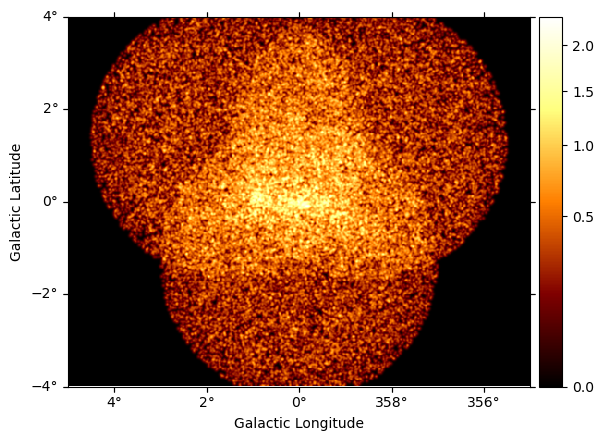

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [27]:
# Let's have a look at those three observations
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)
plt.show()


In [28]:
# How does the background look like?
dataset_stacked.background.plot_interactive(add_cbar=True)
plt.show()


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:517: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy_true, radius, label=label, **kwargs)
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:563: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(rad, psf_value, label=label, **kwargs)
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:563: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(rad, psf_value, label=label, **kwargs)


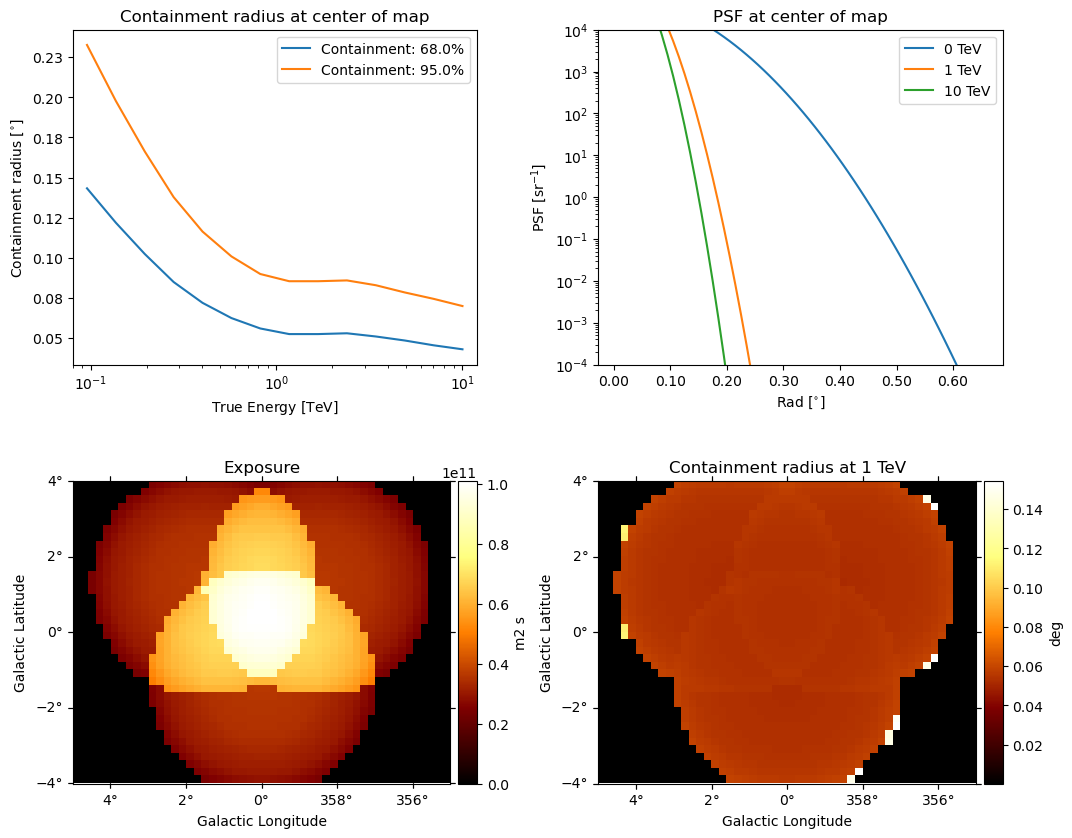

In [29]:
#What about the PSF?
dataset_stacked.psf.peek()
plt.show()

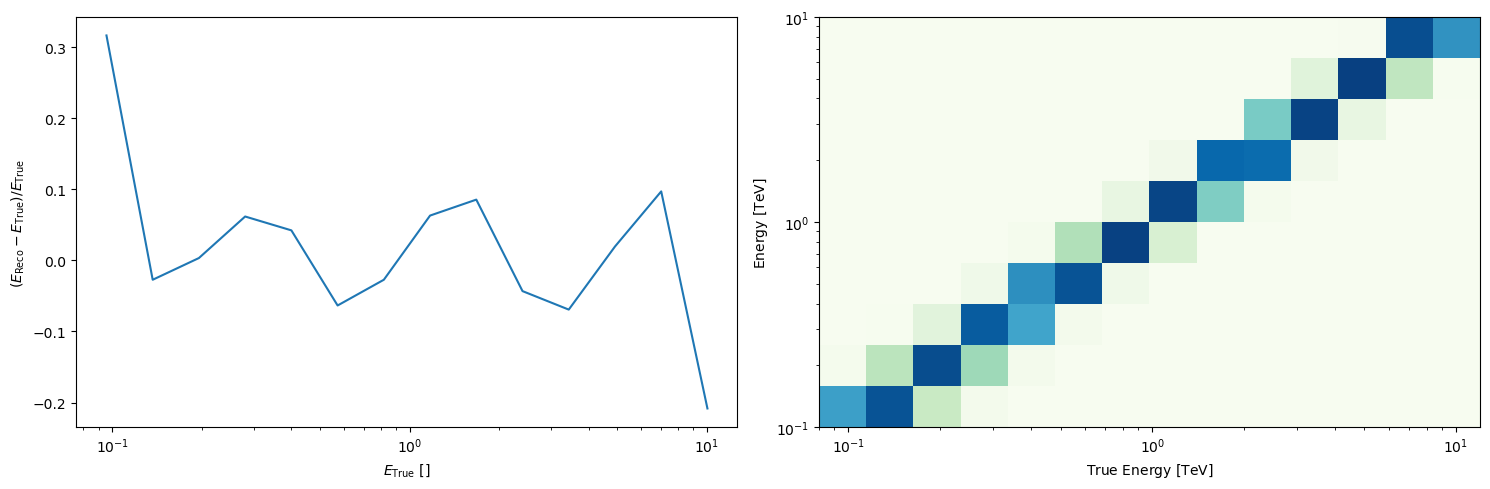

In [30]:
# Same for energy dispersion
dataset_stacked.edisp.peek()
plt.show()



In [31]:
# So we can have a first guess of what would be the excess
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(add_cbar=True)
plt.show()

But let's fo to the model fitting. We can start from a point source model with an exponential cutoff power-law spectrum. To restrict the fit to a particular energy range, we can create a specific mask using the function energy_mask(). On the dataset, the mask_fit is a Map sharing the same geometry as the MapDataset and containing boolean data.

In [32]:
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.3 * u.TeV, energy_max=None # Why this? You will se later
)

And now let's create the sky model

In [33]:
spatial_model = PointSpatialModel(
    lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

# In consequence, we create a model for a point source with a PL with an ExpCutoff, 
# i.e. we are attempting to fit Sgr A*
model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

In [34]:
### But now we have not done any background subtraction (reflected or ring backgrounds). 
# We will use instead the FoV map that we checked before

bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.spectral_model.norm.value = 1.3

#So in order to finish the analysis, we need to combine both
models_stacked = Models([model, bkg_model])

dataset_stacked.models = models_stacked

In [35]:
# And then we fit
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset_stacked])
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 185
	total stat : 180458.61

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [36]:
display(models_stacked.to_parameters_table())

<Table length=10>
   model    type    name      value    ...    max    frozen link prior
   str11    str1    str9     float64   ...  float64   bool  str1  str1
----------- ---- --------- ----------- ... --------- ------ ---- -----
  gc-source          index  2.4159e+00 ...       nan  False           
  gc-source      amplitude  2.6566e-12 ...       nan  False           
  gc-source      reference  1.0000e+00 ...       nan   True           
  gc-source        lambda_ -1.4045e-02 ...       nan  False           
  gc-source          alpha  1.0000e+00 ...       nan   True           
  gc-source          lon_0 -4.8087e-02 ...       nan  False           
  gc-source          lat_0 -5.2600e-02 ... 9.000e+01  False           
stacked-bkg           norm  1.3481e+00 ...       nan  False           
stacked-bkg           tilt  0.0000e+00 ...       nan   True           
stacked-bkg      reference  1.0000e+00 ...       nan   True

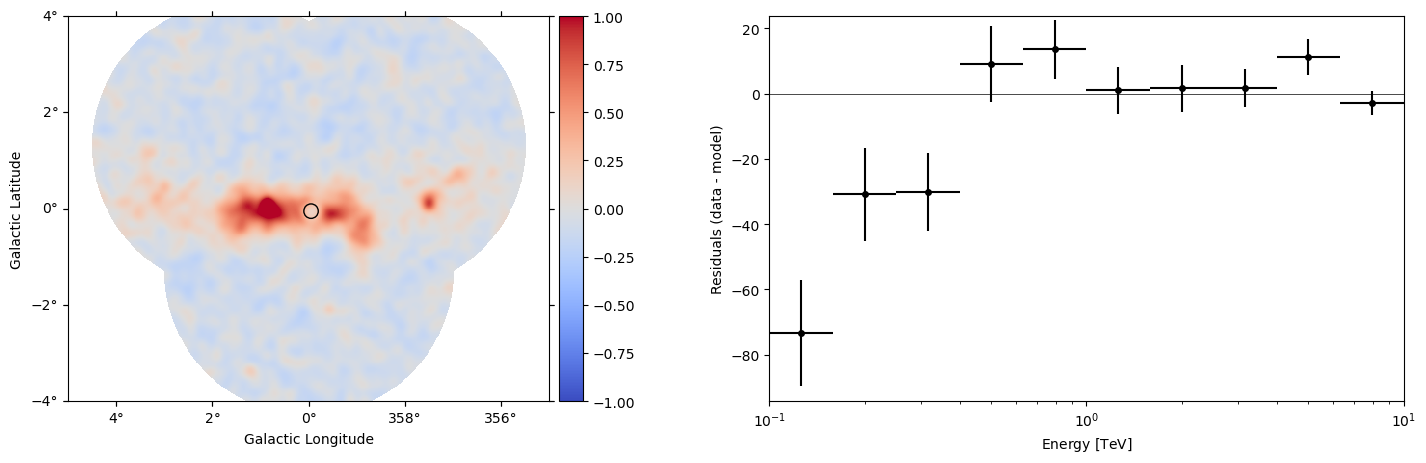

In [37]:
## Let's check the residuals

region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(18, 5),
)
    
dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1), # diff means (data - model)
    kwargs_spectral=dict(region=region),
)
plt.show()

# This way doesn't take into account the energy range mask that we may have applied


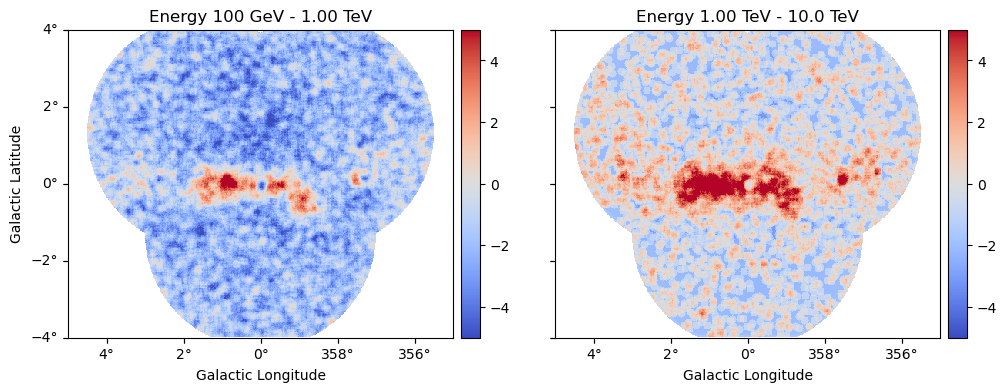

In [38]:
#More precisely it could be, were we use again an estimator! And we can do it for different energy ranges

estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
)

result = estimator.run(dataset_stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()


In [39]:
significance_map = result["sqrt_ts"]

kwargs_hist = {"density": True, "alpha": 0.9, "color": "red", "bins": 40}

ax, res = plot_distribution(
    significance_map,
    func="norm",
    kwargs_hist=kwargs_hist,
    kwargs_axes={"xlim": (-5, 5)},
)
plt.show()

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


You could now tehnically do a joint fit of the observations, instead. Since it is considerably more time consuming, we won't do it now.

*Exercise: There is a second bright source in the FoV (G0.9+0.1). Could you include it in your analysis? Derive an SED from this analysis with the tools from Tuesday. What about diffuse emission? Is the Fermi-LAT template useful for this simulated data?*

In [40]:
# HINT: How to create the diffuse model
diffuse_galactic_fermi = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz")
# Ideally, you would use the latest template from the CTA Consortium 
# Paper: "Prospects for a survey of the Galactic plane with the Cherenkov Telescope Array"
# Repository: https://zenodo.org/records/10008527

template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)  # the template model in this case is already a full 3D model, it should not be normalised

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem"
)  # A power law spectral correction is applied in this case


# Note: this is not only for diffuse templates...  but your own models!

Once you are convinced that your fit is adequate, you can proceed and evaluate the source significance above background. For this we define our H0 (null) hypothesis as the background component only, and the H1 hypothesis as the source has a flux larger than 0.

In [41]:
# We fix all components except for the amplitude

model.spatial_model.lon_0.frozen = True
model.spatial_model.lat_0.frozen = True

model.spectral_model.amplitude.frozen = False
model.spectral_model.index.frozen = True
model.spectral_model.lambda_.frozen = True

bkg_model.spectral_model.norm.frozen = True

In [42]:
# And we need to add that to the dataset
models_stacked = Models([model, bkg_model])

dataset_stacked.models = models_stacked

In [43]:
# Again, let's confirm we do what we think we are doing
display(models_stacked.to_parameters_table())

<Table length=10>
   model    type    name      value    ...    max    frozen link prior
   str11    str1    str9     float64   ...  float64   bool  str1  str1
----------- ---- --------- ----------- ... --------- ------ ---- -----
  gc-source          index  2.4159e+00 ...       nan   True           
  gc-source      amplitude  2.6566e-12 ...       nan  False           
  gc-source      reference  1.0000e+00 ...       nan   True           
  gc-source        lambda_ -1.4045e-02 ...       nan   True           
  gc-source          alpha  1.0000e+00 ...       nan   True           
  gc-source          lon_0 -4.8087e-02 ...       nan   True           
  gc-source          lat_0 -5.2600e-02 ... 9.000e+01   True           
stacked-bkg           norm  1.3481e+00 ...       nan   True           
stacked-bkg           tilt  0.0000e+00 ...       nan   True           
stacked-bkg      reference  1.0000e+00 ...       nan   True

In [44]:
# And we compute it!
parameters = [model.spectral_model.amplitude]
null_values = [0] #that is, amplitude = 0 is equivalent to no source
n_free_parameters = len(model.parameters.free_parameters)

results = select_nested_models(datasets=dataset_stacked,
                                 parameters=parameters,
                                 null_values=null_values,
                                 n_sigma=-np.inf,
                                 n_free_parameters=n_free_parameters
                                )
print(results['fit_results'])

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 17
	total stat : 180458.60

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [45]:
# And we can now see the result from the TS
results['ts']

1288.880064837489

In [46]:
#And convert it to sigma adequately
print(ts_to_sigma(results['ts'], df=n_free_parameters))

35.90097582012903
